# LIBRARIES

In [ ]:
# Importing all the necessary libraries for this assessment 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

#Importing Random Libraries and setting seed 
import random 
torch.manual_seed(100)
torch.cuda.manual_seed(100)
random.seed(100)

In [ ]:
# Switiching from cpu to gpu for better performance and faster processsing

set_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# HYPERPARAMETER

In [ ]:
# Defining the hyperparamters
batch_size = 50  # Batch Size  
count_epochs = 10  # Epochs 
global_learning_rate = 0.002  # Learning Rate
loss_list = []

# Initializing an empty dictionary 
model_accuracies = {}

In [ ]:
# Executing data Preprocessing and augmentation. Following the split, the complete dataset—train and test—is subjected to transformations, such as normalization.

train_data_transformed = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_data_transformed = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
def perform_data_loading(batch_size):

    # Dividing the data according to the CIFAR dataset's preset training and test sets. To enable speedier data loading, we have maintained num_workers at 4 for better performance

    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_data_transformed)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4) 

    test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_data_transformed)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)  
    
    return train_data_loader, test_data_loader

In [ ]:
# Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)  
        self.bn4 = nn.BatchNorm1d(128)  
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.c1(x))))
        x = self.pool(F.relu(self.bn2(self.c2(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))  
        x = self.dropout(x)
        x = self.fc3(x)  
        return x

In [ ]:
# Define our Scheduler for Learning Rates 

def def_learning_rate_scheduler(optimizer, epoch):
    learning_rate = global_learning_rate
    if epoch >= 15:
        learning_rate /= 10

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

In [ ]:
# Getting our model trained. This code applies to all of the models we use today.

def model_training(recieved_model, train_data_loader, count_epochs):
    recieved_model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(recieved_model.parameters(), lr=global_learning_rate, weight_decay=5e-4)  # Using Adam optimizer
    accuracy_list = []

    for epoch in range(count_epochs):

        r_loss = 0.0
        correct = 0
        total = 0

        def_learning_rate_scheduler(optimizer, epoch)
        
        # To further understand our findings, we utilize the TQDM library.

        with tqdm(train_data_loader, unit="batch", bar_format="{l_bar}{bar:40}{r_bar}") as t:
            t.set_description(f"Epoch {epoch + 1}")

            for i, data in enumerate(t, 0):
                input_data, data_labels = data
                input_data, data_labels = input_data.to(set_gpu), data_labels.to(set_gpu)
                optimizer.zero_grad()
                outputs = recieved_model(input_data)
                loss = criterion(outputs, data_labels)
                loss.backward()
                optimizer.step()
                r_loss += loss.item()
                
                _, prediction = torch.max(outputs.data, 1)
                total += data_labels.size(0)
                correct += (prediction == data_labels).sum().item()
            
                # Add to the loss list the epoch's average loss.
            loss_list.append(r_loss / len(train_data_loader))

            accuracy = 100 * correct / total
            accuracy_list.append(accuracy)

            t.set_postfix(loss=f"{r_loss / len(train_data_loader):.4f}", accuracy=f"{accuracy:.2f}%")
            
            print(f"Epoch {epoch + 1}/{count_epochs}, Loss: {r_loss / len(train_data_loader):.4f}, Accuracy: {accuracy:.2f}%")
    
    print("Finished Training")
    
    return accuracy_list

In [ ]:
# Analysis of our model. Similar to training, all of our current models share this code.

def model_evalutaion(recieved_model, test_data_loader):
    recieved_model.eval()
    correct_hit = 0
    total_hit = 0

    with torch.no_grad():
        for data in test_data_loader:
            images_data, labels_data = data
            images_data, labels_data = images_data.to(set_gpu), labels_data.to(set_gpu)
            outputs = recieved_model(images_data)
            _, predicted = torch.max(outputs.data, 1)
            total_hit += labels_data.size(0)
            correct_hit += (predicted == labels_data).sum().item()
    
    accuracy = 100 * correct_hit / total_hit
    print(f"Accuracy on the test set: {accuracy}%")

    return accuracy

In [ ]:
# Assign our data loaders to add information to our variables.

loader_train_data, loader_test_data = perform_data_loading(batch_size)

# Make a list of training data batches.
loader_train_data = [(inputs.to(set_gpu), labels.to(set_gpu)) for inputs, labels in loader_train_data]

# Make a list of the test data batches.
loader_test_data = [(inputs.to(set_gpu), labels.to(set_gpu)) for inputs, labels in loader_test_data]

# Transfer the model over to the GPU.
model_CNN = CNN()
model_CNN.to(set_gpu)

Files already downloaded and verified
Files already downloaded and verified


CNN(
  (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
#Building the CNN model and training it

accuracy_list = model_training(model_CNN, loader_train_data, count_epochs)

model_name = 'CNN'
accuracy = model_evalutaion(model_CNN, loader_test_data) 
model_CNN= model_CNN.cpu()
model_accuracies[model_name] = accuracy

Epoch 1: 100%|████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.49batch/s]


Epoch 1/10, Loss: 1.5314, Accuracy: 44.66%


Epoch 2: 100%|████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.34batch/s]


Epoch 2/10, Loss: 1.2643, Accuracy: 55.39%


Epoch 3: 100%|████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.93batch/s]


Epoch 3/10, Loss: 1.1586, Accuracy: 59.50%


Epoch 4: 100%|████████████████████████████████████████| 1000/1000 [00:43<00:00, 22.79batch/s]


Epoch 4/10, Loss: 1.0733, Accuracy: 62.59%


Epoch 5: 100%|████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.56batch/s]


Epoch 5/10, Loss: 1.0016, Accuracy: 65.45%


Epoch 6: 100%|████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.50batch/s]


Epoch 6/10, Loss: 0.9402, Accuracy: 67.56%


Epoch 7: 100%|████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.31batch/s]


Epoch 7/10, Loss: 0.8809, Accuracy: 69.76%


Epoch 8: 100%|████████████████████████████████████████| 1000/1000 [00:58<00:00, 17.12batch/s]


Epoch 8/10, Loss: 0.8341, Accuracy: 71.36%


Epoch 9: 100%|████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.14batch/s]


Epoch 9/10, Loss: 0.7919, Accuracy: 72.74%


Epoch 10: 100%|████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.36batch/s]


Epoch 10/10, Loss: 0.7545, Accuracy: 74.05%
Finished Training
Accuracy on the test set: 69.96%


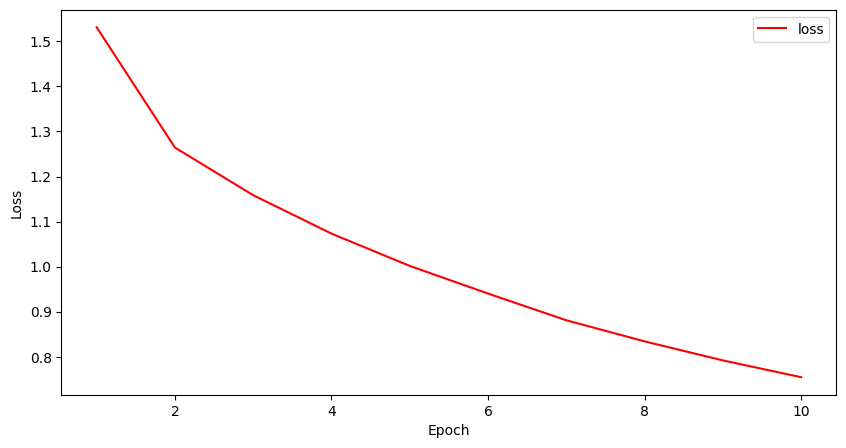

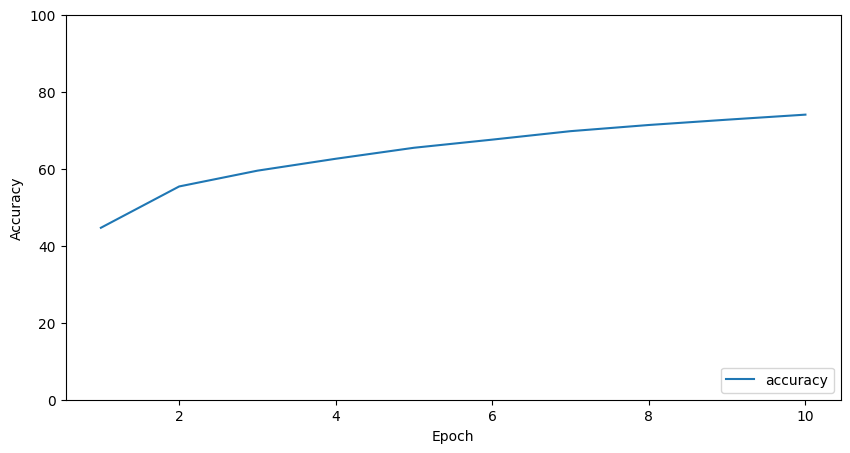

In [ ]:
# Make a new figure for our CNN results' loss vs. epoch plot.

plt.figure(figsize=(10, 5))

#Plotting the graph 
plt.plot(range(1, count_epochs + 1), loss_list, label='loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.figure(figsize=(10, 5))

plt.plot(range(1, count_epochs + 1), accuracy_list, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend(loc='lower right')
plt.show()

# USING DIFFERENCE MODELS

# 1 : LeNet MODEL

Epoch 1: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.96batch/s]


Epoch 1/10, Loss: 1.5197, Accuracy: 45.59%


Epoch 2: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.39batch/s]


Epoch 2/10, Loss: 1.2309, Accuracy: 56.48%


Epoch 3: 100%|████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.27batch/s]


Epoch 3/10, Loss: 1.1136, Accuracy: 60.93%


Epoch 4: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.93batch/s]


Epoch 4/10, Loss: 1.0265, Accuracy: 64.57%


Epoch 5: 100%|████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.57batch/s]


Epoch 5/10, Loss: 0.9649, Accuracy: 66.49%


Epoch 6: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.26batch/s]


Epoch 6/10, Loss: 0.9077, Accuracy: 68.47%


Epoch 7: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.21batch/s]


Epoch 7/10, Loss: 0.8549, Accuracy: 70.23%


Epoch 8: 100%|████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.91batch/s]


Epoch 8/10, Loss: 0.8120, Accuracy: 71.97%


Epoch 9: 100%|████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.48batch/s]


Epoch 9/10, Loss: 0.7727, Accuracy: 73.03%


Epoch 10: 100%|████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.60batch/s]


Epoch 10/10, Loss: 0.7347, Accuracy: 74.41%
Finished Training
Accuracy on the test set: 68.06%


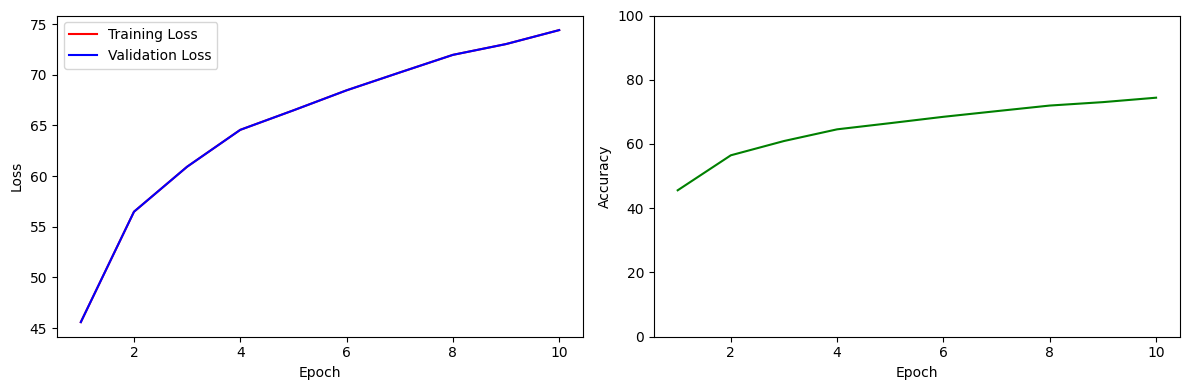

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(3, 32, 5)
        self.c_b1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.c2 = nn.Conv2d(32, 64, 5)
        self.c_b2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.fc2_bn = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.fc3_bn = nn.BatchNorm1d(10)

    def forward(self, x):
        x = self.pool(F.relu(self.c_b1(self.c1(x))))
        x = self.pool(F.relu(self.c_b2(self.c2(x))))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3_bn(self.fc3(x))
        return x


#Building our LeNet framework
model_lenet = LeNet()
model_lenet = model_lenet.to(set_gpu)



history_lenet = model_training(model_lenet, loader_train_data, count_epochs)

# Using the test data to assess the LeNet model

#Assess and record ModifiedLeNet's accuracy.
model_name = 'ModifiedLeNet'
accuracy = model_evalutaion(model_lenet, loader_test_data) 
model_accuracies[model_name] = accuracy
model_lenet=model_lenet.cpu()

train_losses = history_lenet  
val_losses = history_lenet  
val_accuracies = history_lenet  
count_epochs = len(history_lenet)  

# Plot our LeNet model's training and validation losses.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, count_epochs + 1), train_losses, label='Training Loss', color='red')
plt.plot(range(1, count_epochs + 1), val_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# 2 : EfficientNet MODEL

Epoch 1: 100%|████████████████████████████████████████| 1000/1000 [03:52<00:00,  4.30batch/s]


Epoch 1/10, Loss: 1.8992, Accuracy: 27.87%


Epoch 2: 100%|████████████████████████████████████████| 1000/1000 [04:04<00:00,  4.08batch/s]


Epoch 2/10, Loss: 1.6189, Accuracy: 38.83%


Epoch 3: 100%|████████████████████████████████████████| 1000/1000 [04:40<00:00,  3.56batch/s]


Epoch 3/10, Loss: 1.4308, Accuracy: 47.80%


Epoch 4: 100%|████████████████████████████████████████| 1000/1000 [05:28<00:00,  3.05batch/s]


Epoch 4/10, Loss: 1.3103, Accuracy: 52.99%


Epoch 5: 100%|████████████████████████████████████████| 1000/1000 [05:51<00:00,  2.84batch/s]


Epoch 5/10, Loss: 1.2333, Accuracy: 55.99%


Epoch 6: 100%|████████████████████████████████████████| 1000/1000 [06:12<00:00,  2.69batch/s]


Epoch 6/10, Loss: 1.1782, Accuracy: 58.31%


Epoch 7: 100%|████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73batch/s]


Epoch 7/10, Loss: 1.1337, Accuracy: 60.09%


Epoch 8: 100%|████████████████████████████████████████| 1000/1000 [06:10<00:00,  2.70batch/s]


Epoch 8/10, Loss: 1.0962, Accuracy: 61.52%


Epoch 9: 100%|████████████████████████████████████████| 1000/1000 [06:03<00:00,  2.75batch/s]


Epoch 9/10, Loss: 1.0653, Accuracy: 62.61%


Epoch 10: 100%|████████████████████████████████████████| 1000/1000 [06:33<00:00,  2.54batch/s]


Epoch 10/10, Loss: 1.0377, Accuracy: 63.77%
Finished Training
Accuracy on the test set: 60.8%


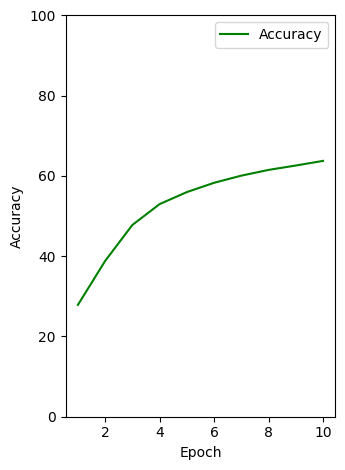

In [ ]:

# Creating a unique EfficientNet model 
from efficientnet_pytorch import EfficientNet

class ModelEfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_name('efficientnet-b0')  
        in_features = self.efficientnet._fc.in_features
        self.efficientnet._fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)


model_efficientnet = ModelEfficientNet(num_classes=10)  


model_efficientnet = model_efficientnet.to(set_gpu)

train_accuracy_list = model_training(model_efficientnet, loader_train_data, count_epochs)

# Assessing ModifiedEfficientNet's storage correctness and the EfficientNet model

model_name = 'ModifiedEfficientNet'
accuracy = model_evalutaion(model_efficientnet, loader_test_data)  # 

model_efficientnet=model_efficientnet.cpu()
# Plotting our EfficientNet model's accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), train_accuracy_list, label='Accuracy', color='Red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()



# 3 : ResNet18 MODEL

C:\Users\Viral Panchal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Viral Panchal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Viral Panchal/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%
Epoch 

Epoch 1/10, Loss: 1.4021, Accuracy: 50.68%


Epoch 2: 100%|████████████████████████████████████████| 1000/1000 [01:53<00:00,  8.79batch/s]


Epoch 2/10, Loss: 1.0996, Accuracy: 62.47%


Epoch 3: 100%|████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.91batch/s]


Epoch 3/10, Loss: 0.9777, Accuracy: 66.77%


Epoch 4: 100%|████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.52batch/s]


Epoch 4/10, Loss: 0.9005, Accuracy: 69.32%


Epoch 5: 100%|████████████████████████████████████████| 1000/1000 [02:45<00:00,  6.03batch/s]


Epoch 5/10, Loss: 0.8406, Accuracy: 71.56%


Epoch 6: 100%|████████████████████████████████████████| 1000/1000 [03:09<00:00,  5.27batch/s]


Epoch 6/10, Loss: 0.7933, Accuracy: 73.27%


Epoch 7: 100%|████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68batch/s]


Epoch 7/10, Loss: 0.7527, Accuracy: 74.38%


Epoch 8: 100%|████████████████████████████████████████| 1000/1000 [03:55<00:00,  4.24batch/s]


Epoch 8/10, Loss: 0.7195, Accuracy: 75.39%


Epoch 9: 100%|████████████████████████████████████████| 1000/1000 [04:16<00:00,  3.90batch/s]


Epoch 9/10, Loss: 0.6919, Accuracy: 76.46%


Epoch 10: 100%|████████████████████████████████████████| 1000/1000 [04:58<00:00,  3.35batch/s]


Epoch 10/10, Loss: 0.6648, Accuracy: 77.19%
Finished Training
Accuracy on the test set: 67.1%


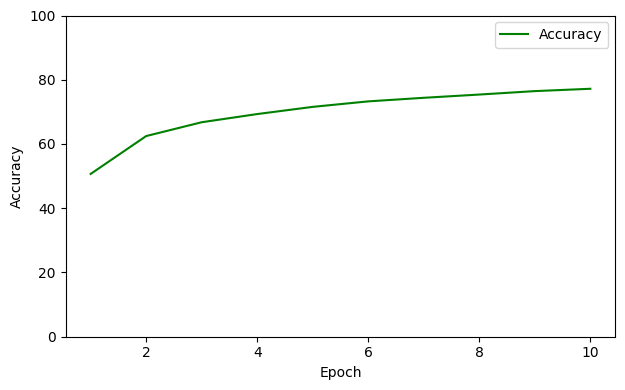

In [ ]:
# Describe our unique ResNet18 model.

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet18(x)

model_resnet18 = ResNet18()
model_resnet18 = model_resnet18.to(set_gpu)


accuracy_list_resnet = model_training(model_resnet18, loader_train_data, count_epochs)


model_name = 'ModifiedResNet18'
accuracy = model_evalutaion(model_resnet18, loader_test_data)  
model_accuracies[model_name] = accuracy
model_resnet18=model_resnet18.cpu()

plt.figure(figsize=(12, 4))

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), accuracy_list_resnet, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

# 4 : ResNet50 MODEL

C:\Users\Viral Panchal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Viral Panchal/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%
Epoch 1: 100%|████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.34batch/s]


Epoch 1/10, Loss: 1.4525, Accuracy: 48.06%


Epoch 2: 100%|████████████████████████████████████████| 1000/1000 [04:42<00:00,  3.54batch/s]


Epoch 2/10, Loss: 1.1895, Accuracy: 58.77%


Epoch 3: 100%|████████████████████████████████████████| 1000/1000 [06:22<00:00,  2.62batch/s]


Epoch 3/10, Loss: 1.1011, Accuracy: 62.00%


Epoch 4: 100%|████████████████████████████████████████| 1000/1000 [07:14<00:00,  2.30batch/s]


Epoch 4/10, Loss: 1.0218, Accuracy: 65.03%


Epoch 5: 100%|████████████████████████████████████████| 1000/1000 [08:19<00:00,  2.00batch/s]


Epoch 5/10, Loss: 0.9506, Accuracy: 67.33%


Epoch 6: 100%|████████████████████████████████████████| 1000/1000 [09:19<00:00,  1.79batch/s]


Epoch 6/10, Loss: 0.8956, Accuracy: 69.22%


Epoch 7: 100%|████████████████████████████████████████| 1000/1000 [10:19<00:00,  1.62batch/s]


Epoch 7/10, Loss: 0.8512, Accuracy: 70.73%


Epoch 8: 100%|████████████████████████████████████████| 1000/1000 [11:43<00:00,  1.42batch/s]


Epoch 8/10, Loss: 0.8208, Accuracy: 71.85%


Epoch 9: 100%|████████████████████████████████████████| 1000/1000 [13:49<00:00,  1.21batch/s]


Epoch 9/10, Loss: 0.7918, Accuracy: 72.85%


Epoch 10: 100%|████████████████████████████████████████| 1000/1000 [14:44<00:00,  1.13batch/s]


Epoch 10/10, Loss: 0.7700, Accuracy: 73.65%
Finished Training
Accuracy on the test set: 71.26%


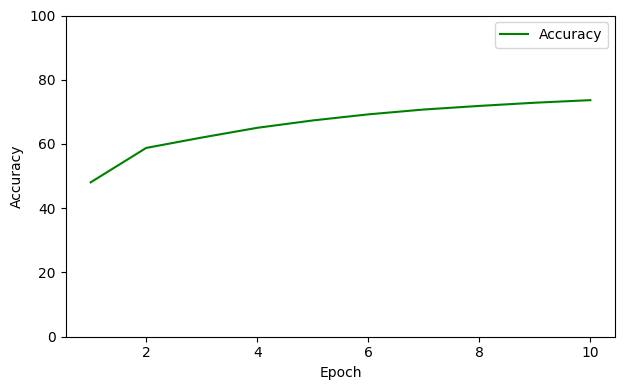

In [19]:
# Specifying our own ResNet50 model.

class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet50(x)

resnet50mod = ResNet50()


resnet50mod = resnet50mod.to(set_gpu)


accuracy_list_resnet50 = model_training(resnet50mod, loader_train_data, count_epochs)


model_name = 'ModifiedResNet50'
accuracy = model_evalutaion(resnet50mod, loader_test_data)  
model_accuracies[model_name] = accuracy
resnet50mod=resnet50mod.cpu()

plt.figure(figsize=(12, 4))

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, count_epochs + 1), accuracy_list_resnet50, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()

# EXAMINING THE ACCURACY OF THE ABOVE MODELS AND CREATING A HISTOGRAM OF IT

CNN Accuracy: 69.96%
ModifiedLeNet Accuracy: 68.06%
ModifiedEfficientNet Accuracy: 60.80%
ModifiedResNet18 Accuracy: 67.10%
ModifiedResNet50 Accuracy: 71.26%


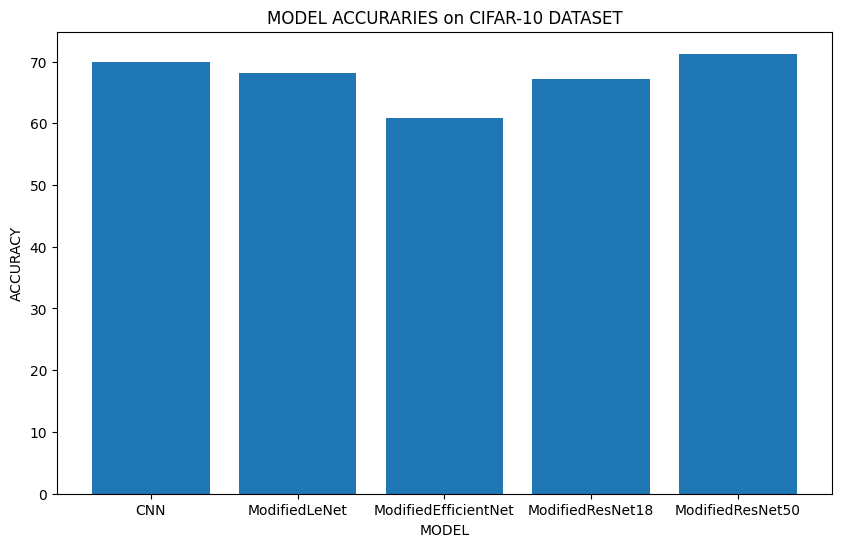

In [20]:
# Print the accuracy of the model
for model_CNN, accuracy in model_accuracies.items():
    print(f"{model_CNN} Accuracy: {accuracy:.2f}%")

# Producing a model accuracy histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('MODEL')
plt.ylabel('ACCURACY')
plt.title('MODEL ACCURARIES on CIFAR-10 DATASET')
plt.show()